# Generate quantum wave function figures

This notebook contains code for generating the panels of Figure 1 in Manning (2020).

## Basic setup (import statements and font settings)

In [13]:
import warnings
warnings.simplefilter('ignore')

import os
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter

from scipy.stats import norm

In [14]:
SMALL_SIZE = 12
MEDIUM_SIZE = 18
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Define simulation parameters and figure directory

In [15]:
t = np.linspace(-10, 7.5, 1000) #time
dt = (np.max(t) - np.min(t)) / len(t)

now = 0
past = -5
related1 = -7.5
related2 = -2.5
future1 = 2
future2 = 3.5
future3 = 5
events = [related1, past, related2, now, future1, future2, future3]
symbols = ['$\\star$', '$\\bigstar$', '$\\star$', '$\\blacktriangle$', '$\\diamond$', '$\\diamond$', '$\\diamond$']

figdir = os.path.join(os.path.split(os.path.split(os.getcwd())[0])[0], 'paper', 'figs', 'source')
if not os.path.exists(figdir):
    os.makedirs(figdir)

## Helper functions related to indexing, plotting, and running simulations

In [16]:
def where(t, x):
    diffs = np.abs(t - x)
    return np.min(np.where(diffs == np.min(diffs))[0])

In [17]:
def decay(x, n, dt, tau):
    #x: initial value
    #n: number of timesteps
    #dt: change in time per timestep
    #tau: decay rate
    
    y = np.zeros(n)
    y[0] = x
    
    for i in range(1, n):
        y[i] = (1 - dt) * tau * (y[i - 1])
    return y

def normpdf(t, mu, sigma): #normal probability density function re-scaled to have a max of 1
    x = norm.pdf(t, mu, sigma)
    return x / np.max(x)

In [18]:
def waveplot(x, title=''):    
    
    def event_labels(x, pos):
        if x in events:
            return symbols[where(events, x)]
        else:
            return ''
    
    colors = sns.cubehelix_palette(n_colors=len(taus))
    fig, ax = plt.subplots()
    ax.xaxis.set_major_formatter(FuncFormatter(event_labels))
    
    for i in range(x.shape[0]):
        plt.plot(t, x[i, :], color=colors[i])
    
    plt.ylim((-0.025, 1.025))
    plt.xlim((np.min(t), np.max(t)))
    plt.xticks(events)
    plt.xlabel('Time')
    plt.ylabel('$\\Psi(t)$ (normalized)')
    plt.title(title)
    
    if len(title) > 0:
        fname = os.path.join(figdir, 'waveplot_' + title.lower().replace(' ', '_') + '.pdf')
        plt.savefig(fname, bbox_inches='tight')

## Figure 1A

In [21]:
#context: thoughts now are a recency-weighted blend of prior moments
taus = np.linspace(0.85, 0.999999999, num=10)
context = np.zeros([len(taus), len(t)])

for i, tau in enumerate(taus):
    context[i, 0:where(t, now)] = decay(1, where(t, now), dt, tau)[::-1]

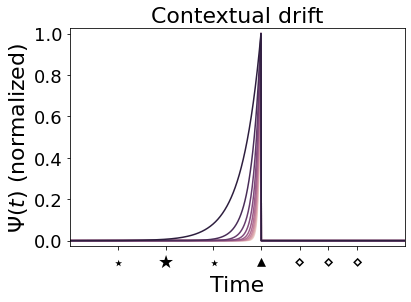

In [20]:
waveplot(context, title='Contextual drift')

## Figure 1B

In [22]:
#mental time travel: thoughts now are a recency-weighted blend of prior moments + gaussian centered on one prior moment

mu = 0.6 #how much are you thinking of now vs the past?

sigmas = np.linspace(0.1, 1, len(taus))
mtt = context.copy()

for i, sigma in enumerate(sigmas):
    x = (1 - mu) * normpdf(t, past, sigma)
    mtt[i, :] *= mu
    mtt[i, :] += x
    mtt[i, :] /= np.max(mtt[i, :])

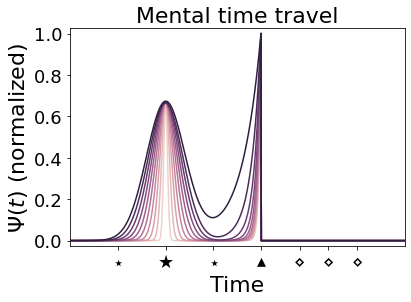

In [23]:
waveplot(mtt, 'Mental time travel')

## Figure 1C

In [24]:
#quantum memory waves: thoughts now combine:
#  - a recency-weighted blend of prior moments
#  - gaussians centered on several moments, weighted by how much they're related to what you're remembering

mu = [0.25, 0.4, 0.1, 0.6] #how much are you thinking about relevant event 1, target event, relevant event 2, and now, respectively

qwf = context.copy()

for i, sigma in enumerate(sigmas):
    qwf[i, :] *= mu[3]
    
    x = mu[0] * normpdf(t, related1, sigma)
    x += mu[1] * normpdf(t, past, sigma)
    x += mu[2] * normpdf(t, related2, sigma)
    qwf[i, :] += x
    
    qwf[i, :] /= np.max(qwf[i, :])

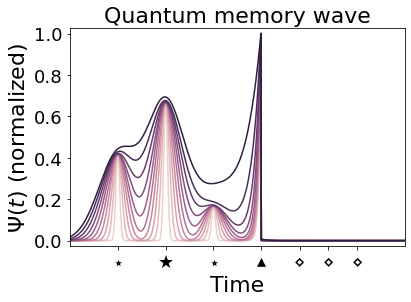

In [25]:
waveplot(qwf, title='Quantum memory wave')

## Figure 1D

In [26]:
#future predictions: thoughts now combine a weighted blend of recent moments, prior remembered moments and related moments, and several future events

mu.extend([0.15, 0.3, 0.2]) #how much are you thinking about:
# - related past event 1
# - target past event
# - related past event 2
# - now
# - future event 1
# - future event 2
# - future event 3

events = [related1, past, related2, now, future1, future2, future3]

future = np.zeros_like(qwf)

for i, sigma in enumerate(sigmas):
    x = np.zeros_like(t)
    
    for m, e in zip(mu, events):
        x += m * normpdf(t, e, sigma)
    
    future[i, :] = x / np.max(x)        

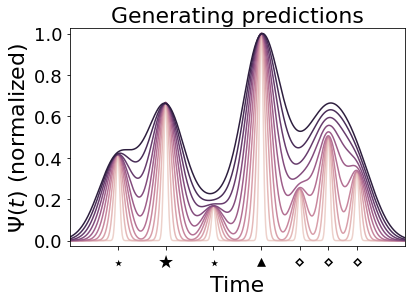

In [27]:
waveplot(future, title='Generating predictions')